<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Chain-Rule-and-Backpropagation" data-toc-modified-id="Chain-Rule-and-Backpropagation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Chain Rule and Backpropagation</a></span></li><li><span><a href="#Momentum" data-toc-modified-id="Momentum-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Momentum</a></span></li><li><span><a href="#Intuitions" data-toc-modified-id="Intuitions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Intuitions</a></span></li><li><span><a href="#Adaptive-learning-rate" data-toc-modified-id="Adaptive-learning-rate-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Adaptive learning rate</a></span></li><li><span><a href="#AdamW" data-toc-modified-id="AdamW-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>AdamW</a></span></li></ul></li></ul></div>

# Training

What is happening in the training loop? <br>
DL5 [1:33:21]
Currently, we are passing off the updating of weights to PyTorch’s optimizer. 
What does an optimizer do? and what is a **momentum**?

We are going to implement Gradient Descent (GD) in an excel sheet (graddesc.xlsm) 
— see worksheets right to left. 
First we create a random x’s, and y’s that are linearly correlated with the x’s (e.g. `y= a*x + b`). 
By using sets of x’s and y’s, we will try to learn a and b.

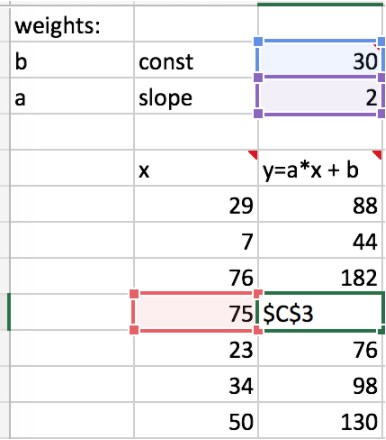

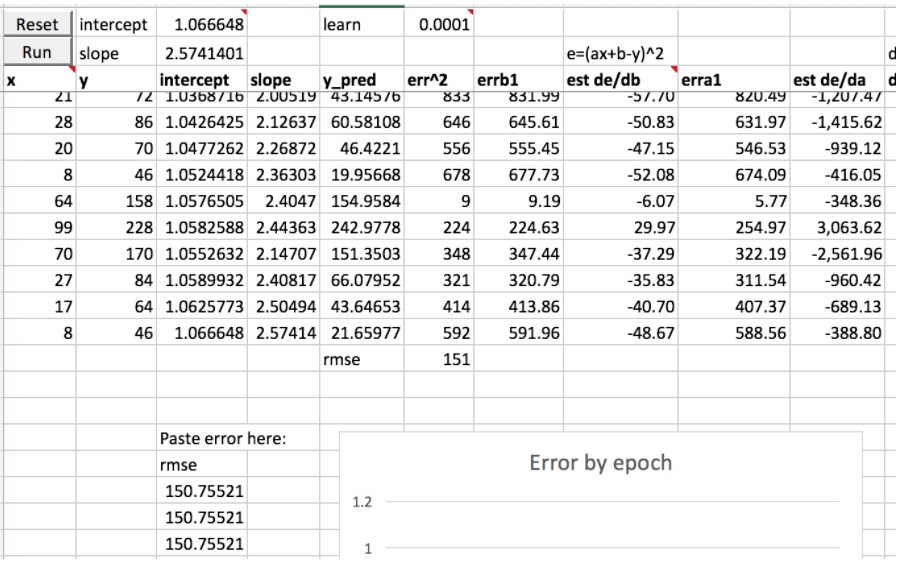

To calculate the error, we first need a prediction, and square the difference:
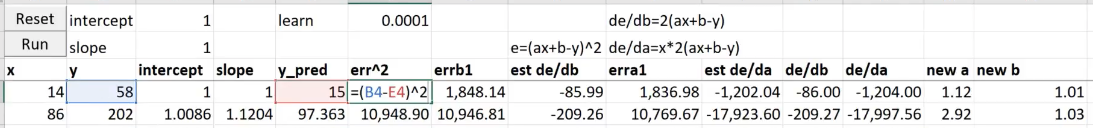

To reduce the error, we increase/decrease a and b a little bit and figure out what would make the error decrease. This is called finding the derivative through finite differencing.

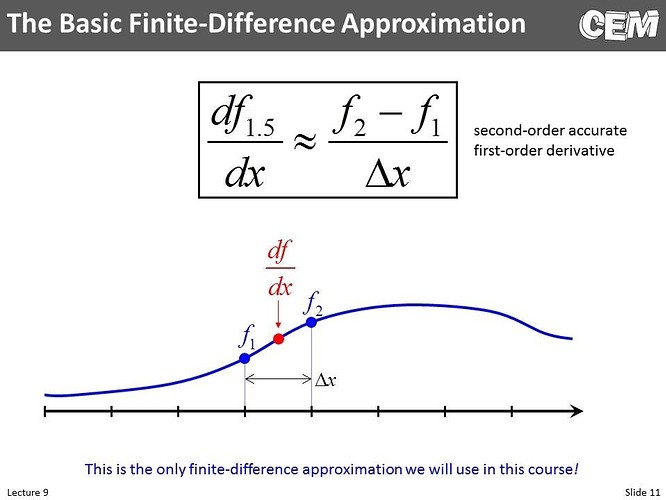

Finite differencing gets complicated in high dimensional spaces [1:41:46], and it becomes very memory intensive and takes a long time. So we want to find some way to do this more quickly. It is worthwhile to look up things like Jacobian and Hessian (Deep Learning book: section 4.3.1 page 84).

## Chain Rule and Backpropagation
The faster approach is to do this analytically [1:45:27]. For this, we need a chain rule:
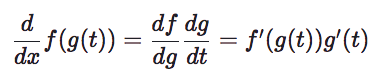

See [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/)
a great article by Chris Olah on Backpropagation as a chain rule.

Now we replace the finite-difference with an actual derivative [WolframAlpha](https://www.wolframalpha.com/) gave us (notice that finite-difference output is fairly close to the actual derivative and good way to do quick sanity check if you need to calculate your own derivative):
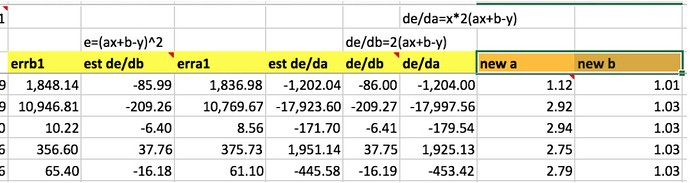
“Online” training — mini-batch with size 1
And this is how you do SGD with excel sheet. If you were to change the prediction value with the output from CNN spreadsheet, we can train CNN with SGD.


## Momentum 
DL5 [1:53:47]
Come on, take a hint — that’s a good direction. Please keep doing that but more.
With this approach, we will use a linear interpolation between the current mini-batch’s derivative and the step (and direction) we took after the last mini-batch (cell K9):
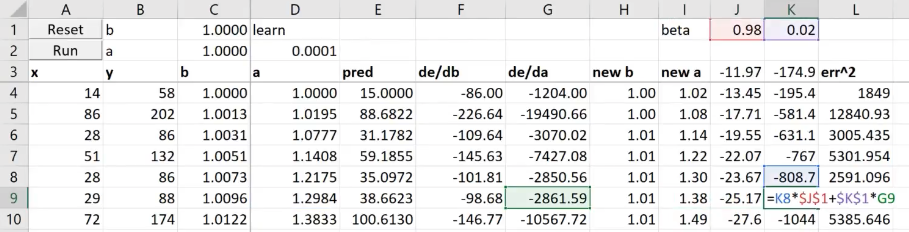
Compared to de/db whose sign (+/-) is random, the one with momentum will keep going the same direction a little bit faster up till certain point. This will reduce a number of epochs required for training.

Adam [1:59:04]
Adam is much faster but the issue has been that final predictions are not as good as as they are with SGD with momentum. It seems as though that it was due to the combined usage of Adam and weight decay. The new version that fixes this issue is called AdamW.

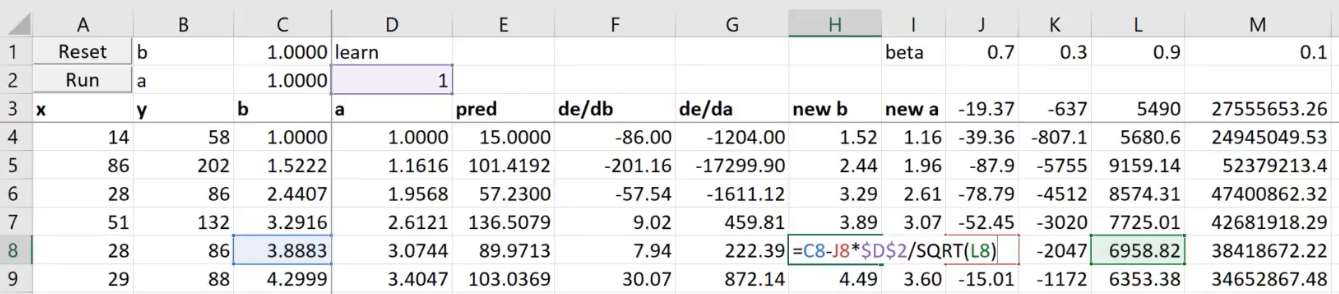

- cell J8 : a linear interpolation of derivative and previous direction (identical to what we had in momentum)
- cell L8 : a linear interpolation of derivative squared + derivative squared from last step ( cell L7)
- “exponentially weighted moving average” (in another words, average with previous values multiplicatively decreased)
Learning rate is much higher than before because we are dividing it by square root of L8 .

Notice in fastai/model.py fit() function, it does not just calculate average loss, but it is calculating the exponentially weighted moving average of loss.
```
avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
```

Another helpful concept is whenever you see `α(…) + (1-α)(…)`, immediately think linear interpolation.



## Intuitions
- We calculated exponentially weighted moving average of gradient squared ($\nabla^2$), 
take a square root of that, and divided the learning rate by it.
$\mu \div \sqrt{\nabla^2}$.
- Gradient squared is always positive.
- When there is high variance in gradients, gradient squared will be large.
- When the gradients are constant, gradient squared will be small.
- If gradients are changing a lot, we want to divide the learning rate by a big number (slow down)
- If gradients are not changing much, we will take a bigger step by dividing the learning rate with a small number

## Adaptive learning rate
keep track of the average of the squares of the gradients and use that to adjust the learning rate. 
So there is just one learning rate, but effectively every parameter at every epoch is getting a bigger jump if the gradient is constant; smaller jump otherwise.
There are two momentums — one for gradient, and the other for gradient squared 
(in PyTorch, it is called a beta which is a tuple of two numbers)


## AdamW
[2:11:18]
When there are much more parameters than data points, regularizations become important. 
Like dropout, `weight decay` is a type of regularization. 
Weight decay (`L2 regularization`) penalizes large weights by adding squared weights (times weight decay multiplier) to the loss. 
The loss function wants to keep the weights small because increasing the weights will increase the loss; Hence only doing so when the loss improves by more than the penalty.

The problem is that since we added the squared weights to the loss function, this affects the moving average of gradients and the moving average of the squared gradients for Adam. 
This result in decreasing the amount of weight decay when there is high variance in gradients, and increasing the amount of weight decay when there is little variation. 
In other words, “penalize large weights unless gradients varies a lot” which is not what we intended. 
**AdamW** [Fixing Weight Decay Regularization in Adam](https://arxiv.org/pdf/1711.05101.pdf)removed the weight decay out of the loss function, and added it directly when updating the weights.**